<a href="https://colab.research.google.com/github/Nanosatellite-Lab/pkm-2022/blob/main/PKM_KC_Feces_Telkom_University_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint, EarlyStopping
import itertools
import os
import shutil
import random
import glob
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import os
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
path="/content/drive/MyDrive/Dataset_Feces"
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

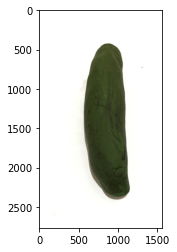

In [ ]:
im = read_image('/content/drive/MyDrive/Dataset_Feces/Hijau/IMG_1003(1).jpg')
plt.imshow(im)

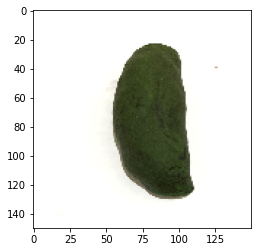

In [ ]:
resized = cv2.resize(im, (150,150))
plt.imshow(resized)

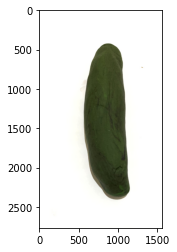

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread, imshow, subplots, show


def plot(data_generator):
    """
    Plots 4 images generated by an object of the ImageDataGenerator class.
    """
    data_generator.fit(images)
    image_iterator = data_generator.flow(images)
    
    # Plot the images given by the iterator
    fig, rows = subplots(nrows=1, ncols=4, figsize=(18,18))
    for row in rows:
        row.imshow(image_iterator.next()[0].astype('int'))
        row.axis('off')
    show()
    
image = imread('/content/drive/MyDrive/Dataset_Feces/Hijau/IMG_1003(1).jpg')

# Creating a dataset which contains just one image.
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

imshow(images[0])
show()

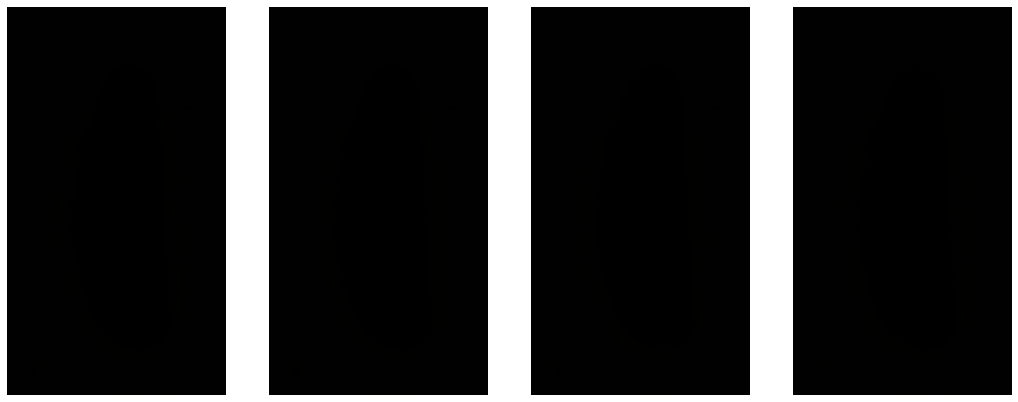

In [ ]:
#reschale
data_generator = ImageDataGenerator(rescale = 1./255)
plot(data_generator)

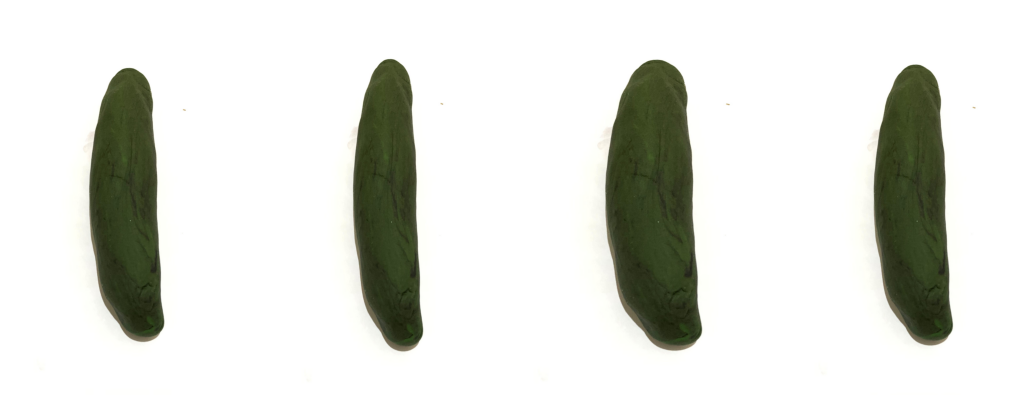

In [ ]:
#Zoom Range 
data_generator = ImageDataGenerator(zoom_range=0.2)
plot(data_generator)

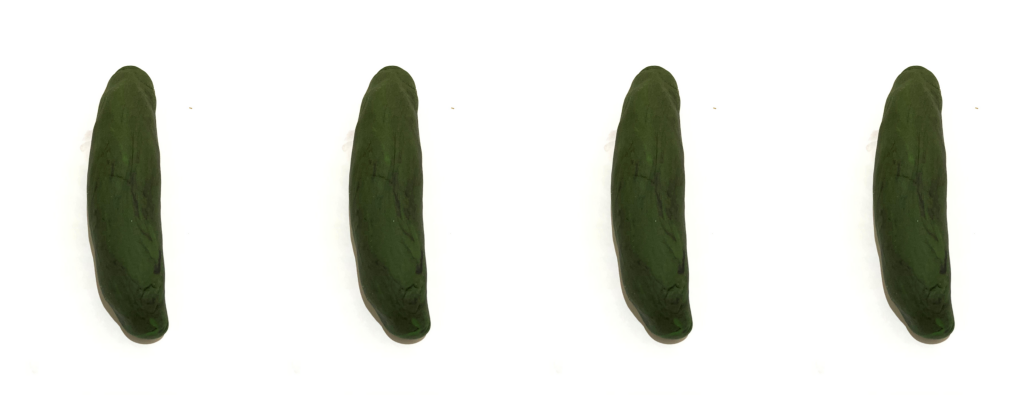

In [ ]:
#shear range 
data_generator = ImageDataGenerator(shear_range=0.2)
plot(data_generator)

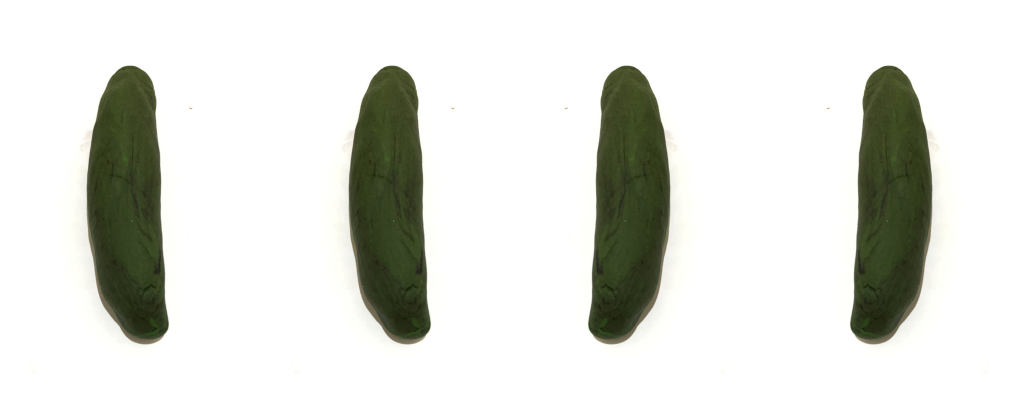

In [ ]:
#Horizontal flip 

data_generator = ImageDataGenerator(horizontal_flip=True)
plot(data_generator)

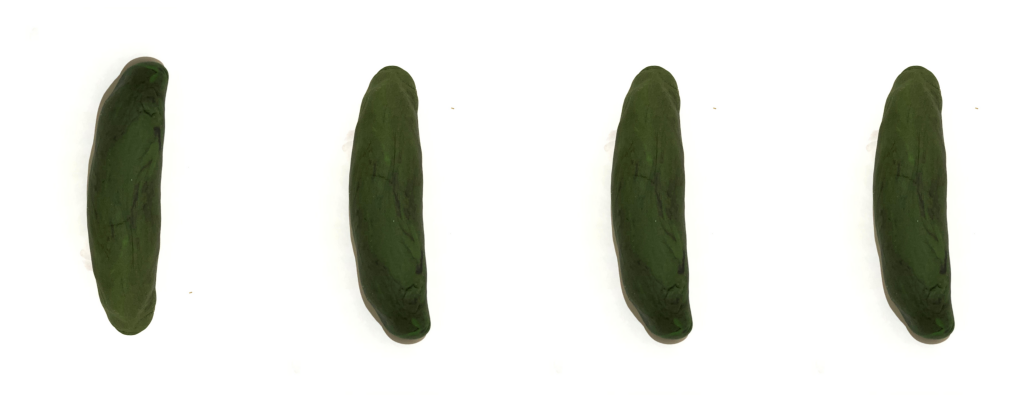

In [ ]:
#vertical flip 

data_generator = ImageDataGenerator(vertical_flip=True)
plot(data_generator)

In [ ]:
data_path = path

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   rotation_range=30,
                                   horizontal_flip = True,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(data_path, 
                                                    shuffle = True,
                                                    batch_size=64, 
                                                    class_mode='categorical',
                                                    subset = 'training',
                                                    target_size=(227,227))

valid_generator = train_datagen.flow_from_directory(
    data_path, 
    shuffle = True,
    batch_size=64,
    class_mode='categorical',
    subset = 'validation',
    target_size=(227,227))

Found 336 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [ ]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3)))

model.add(Dropout(0.3))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.3))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.3))

model.add(BatchNormalization())

#output layer
model.add(Dense(3,activation="softmax"))

In [ ]:
model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import Callback

class TerminateOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [ ]:
hist=model.fit(x = train_generator, 
          steps_per_epoch = len(train_generator),
          epochs = 100,
          validation_data = valid_generator,
          callbacks = [TerminateOnBaseline(monitor='val_accuracy', baseline=0.9)],
          validation_steps = len(valid_generator),
)

Epoch 1/100
6/6 [==============================] - 72s 11s/step - loss: 1.4361 - accuracy: 0.4077 - val_loss: 1.1246 - val_accuracy: 0.1429
Epoch 2/100
6/6 [==============================] - 19s 3s/step - loss: 0.9080 - accuracy: 0.6131 - val_loss: 1.6483 - val_accuracy: 0.1429
Epoch 3/100
6/6 [==============================] - 19s 4s/step - loss: 0.6084 - accuracy: 0.7500 - val_loss: 3.8152 - val_accuracy: 0.1429
Epoch 4/100
6/6 [==============================] - 21s 4s/step - loss: 0.3927 - accuracy: 0.8571 - val_loss: 7.1250 - val_accuracy: 0.1429
Epoch 5/100
6/6 [==============================] - 19s 3s/step - loss: 0.2811 - accuracy: 0.9077 - val_loss: 11.2623 - val_accuracy: 0.1429
Epoch 6/100
6/6 [==============================] - 19s 3s/step - loss: 0.1824 - accuracy: 0.9435 - val_loss: 13.6170 - val_accuracy: 0.1429
Epoch 7/100
6/6 [==============================] - 19s 3s/step - loss: 0.1984 - accuracy: 0.9286 - val_loss: 15.2134 - val_accuracy: 0.1429
Epoch 8/100
6/6 [======

In [ ]:
model.save('result/batch_32_augmented_90_val_acc.h5')

Text(0.5, 1.0, 'Training and validation loss')

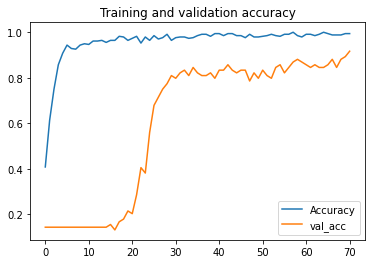

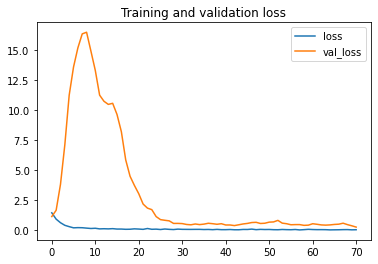

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))
 
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(["Accuracy","val_acc"])
plt.title('Training and validation accuracy')
 
plt.figure()
 
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(["loss","val_loss"])
plt.title('Training and validation loss')

In [ ]:
data_path = path

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   rotation_range=30,
                                   horizontal_flip = True,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(data_path, 
                                                    shuffle = True,
                                                    batch_size=64, 
                                                    class_mode='categorical',
                                                    subset = 'training',
                                                    target_size=(227,227))

valid_generator = train_datagen.flow_from_directory(
    data_path, 
    shuffle = False,
    batch_size=64,
    class_mode='categorical',
    subset = 'validation',
    target_size=(227,227))

Found 336 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [ ]:
predictions = model.predict(x = valid_generator, steps = len(valid_generator), verbose = 0)

In [ ]:
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.Reds):

     plt.imshow(cm, interpolation='nearest', cmap=cmap)
     plt.title(title)
     plt.colorbar()
     tick_marks = np.arange(len(classes))
     plt.xticks(tick_marks, classes, rotation=45)
     plt.yticks(tick_marks, classes)

     if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
     else:
         print('Confusion matrix, without normalization')

     print(cm)

     thresh = cm.max() / 2.
     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

     plt.tight_layout()
     plt.ylabel('Predicted label')
     plt.xlabel('Actual label')


Confusion matrix, without normalization
[[60  0  0]
 [ 2 10  0]
 [ 1  4  7]]


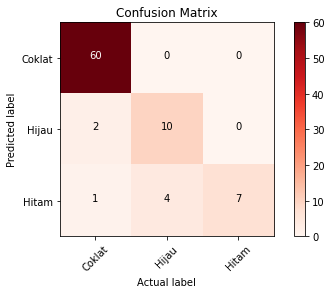

In [ ]:
conf_mat = confusion_matrix(y_true=valid_generator.classes, y_pred=np.argmax(predictions, axis=-1))
conf_mat_plot_labels = ['Coklat', 'Hijau', 'Hitam']
plot_confusion_matrix(cm=conf_mat, classes=conf_mat_plot_labels, title='Confusion Matrix')

In [ ]:
print (classification_report(valid_generator.classes, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.71      0.83      0.77        12
           2       1.00      0.58      0.74        12

    accuracy                           0.92        84
   macro avg       0.89      0.81      0.83        84
weighted avg       0.93      0.92      0.91        84



In [ ]:
model.save('forraspi.h5')